# Trajectory Predictor Training

--- Explanation Paragraph ---

# Notes for later:
- Warn about in-memory dataset. Everything is loaded to memory.
- Update AX optimization cells accordingly.
- Go over more notes at the end.
- Add Kalman AX param optimization to this notebook

In [1]:
import os
os.chdir('/app/Pogona_realtime/Arena')

In [2]:
import numpy as np
import pandas as pd
import imp
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from functools import partial

from Prediction import dataset
from Prediction import train_eval
from Prediction import predictor
from Prediction import visualize
from Prediction import dataset
from Prediction import kalman_predict
from Prediction import seq2seq_predict
from Prediction import calibration as calib
from Prediction import traj_models

## Imp reload

In [3]:
imp.reload(dataset)
imp.reload(train_eval)
imp.reload(seq2seq_predict)
imp.reload(predictor)
imp.reload(visualize)
imp.reload(dataset)
imp.reload(kalman_predict)
imp.reload(traj_models)

<module 'Prediction.traj_models' from '/app/Pogona_realtime/Arena/Prediction/traj_models.py'>

## Load Data

In [4]:
all_df = dataset.collect_data(data_sources={'detections': True, 'timestamps': True, 'dlc': False, 'touches': True})

110 trials loaded


(-824.414605753231,
 2288.9430166168017,
 -395.23839888336073,
 3862.7752047072668)

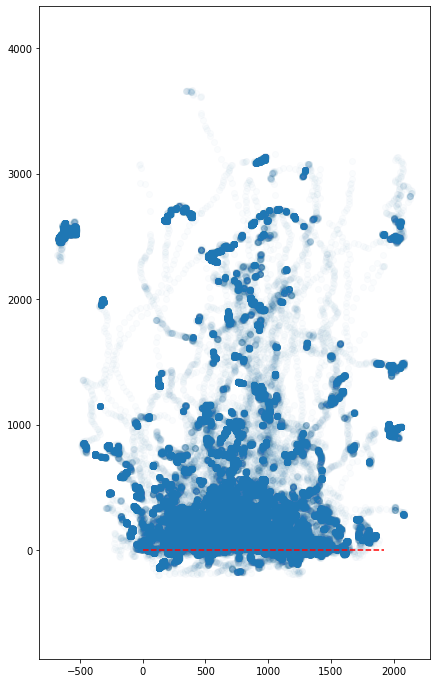

In [5]:
# is this necessary?
plt.figure(figsize=(7,12))
plt.scatter(all_df.x2,all_df.y2,alpha=0.02)
plt.plot(np.linspace(0,1920,num=10),np.zeros(10),color='r',linestyle='--')
plt.axis('equal')

## Train Seq2Seq Trajectory Predictor

### Model Parameters

In [6]:
input_labels = ['x1', 'y1', 'x2', 'y2']
output_labels = ['x1', 'y1', 'x2', 'y2']

net_params = {
    'decoder_type':"Linear",  # "RNN" or "Linear"
    'rnn_type': "GRU",  # "GRU" or "LSTM"
    'use_abs_pos': False,
    'tie_enc_dec': False,
    'use_rnn_cell': True,
    'input_labels': input_labels,
    'output_labels': output_labels,
    'input_dim': len(input_labels),
    'output_dim': len(output_labels),
    'inp_seq_len': 20,
    'out_seq_len': 20,
    'hidden_size': 350,
    'rnn_layers': 1,
    'dropout': 0.05,
}

### Create DataLoader

In [7]:
INF_P = 9999999

mask_dict = {
    'fl_dist': [0, INF_P, True, True],
    'speed': [0, INF_P, True, True],
    'std': [0.0, INF_P, [0,1]],
    'corr': [0.0, 1.0, True, True],
    'zgzg': [0, 1.5, True, True],
    'keep_prob': 0.01
}

mask_fn = train_eval.compose_masks(mask_fns=[
    train_eval.mask_fl_dist(*mask_dict['fl_dist']),
    train_eval.mask_speed(*mask_dict['speed']),
    train_eval.mask_std(*mask_dict['std']),
    train_eval.mask_corr(*mask_dict['corr']),
    train_eval.mask_zgzg(*mask_dict['zgzg'])
    ])

In [8]:
# only necessary once
trials_dict = train_eval.create_samples(df=all_df, 
                                        mask_fn=mask_fn,
                                        keep_prob=mask_dict['keep_prob'],
                                        input_labels=net_params['input_labels'], output_labels=net_params['output_labels'], 
                                        input_seq_size=net_params['inp_seq_len'], output_seq_size=net_params['out_seq_len'])

In [7]:
# run when masking is updated
train_eval.update_trials_dict(trials_dict, mask_fn, keep_prob=mask_dict['keep_prob'])

In [7]:
# generate a new train/val/test trials split
train_trials, val_trials, test_trials = train_eval.split_train_val_test(trials_dict, split=(0.8, 0.1, 0.1))

In [9]:
# use a trials split from a previous training session
model_name = "LSTMdense_1004-1753_i2_o20_h350_l1"
train_trials, val_trials, test_trials = traj_models.get_trials_split(model_name)

### Training Parameters

In [10]:
training_params = {
    'batch_size': 256,
    'clip_grad_norm': 1.5,
    'lr': 0.00005,
    'loss_fn': 'ADE',
    'train_trials': train_trials,
    'val_trials': val_trials,
    'test_trials': test_trials,
    'sched_exp': 0
}

if training_params['loss_fn'] == "weighted ADE":
    # Parameters for exponentialy weighted loss
    # Weights the displacement at the end of the sequence higher than the beginning
    a = np.linspace(0.01, 0.2, num=net_params['out_seq_len'])[::-1]
    loss_weights = np.array([a[t] * np.prod(1-a[:t]) for t in range(len(a))])[::-1]
    training_params['loss_weights'] = loss_weights.tolist()
    loss_dict["weighted ADE"] = partial(train_eval.weighted_ADE, torch.from_numpy(loss_weights.copy()).to('cuda'))


In [11]:
train_dl, val_dl, test_dl = train_eval.create_train_val_test_dataloaders(trials_dict, train_trials, val_trials, test_trials,
                                                                         train_mask=True, val_mask=True, test_mask=False,
                                                                         batch_size=training_params['batch_size'], shuffle=True)

print("Sample size:")
print(f"Training: {len(train_trials)} trials, {len(train_dl.dataset)} seqs")
if val_dl is not None:
    print(f"Validation: {len(val_trials)} trials, {len(val_dl.dataset)} seqs")
if test_dl is not None:
    print(f"Test: {len(test_trials)} trials, {len(test_dl.dataset)} seqs")

Sample size:
Training: 88 trials, 17061 seqs
Validation: 11 trials, 3850 seqs
Test: 11 trials, 44395 seqs


### Train

In [11]:
all_results = []

In [ ]:
model, results, interrupted = traj_models.train_model(training_params, 
                                                      net_params, 
                                                      mask_dict,
                                                      train_dl, 
                                                      val_dl, 
                                                      num_epochs=50, 
                                                      eval_freq=5, 
                                                      log_freq=5, 
                                                      model_name_suffix=None, 
                                                      save_each_eval_model=False)

all_results.append(results)

### Display results

In [ ]:
traj_models.plot_train_results(all_results, "Results", pretty=traj_models.pretty_name, fname="mask_compare")

### Train with multiple output and input sequence lengths

In [ ]:
for out_len in range(2, 21):
    for inp_len in [10,20]:
        
        print(f"============================ IN {inp_len} OUT {out_len} ============================")
        
        net_params['inp_seq_len'] = inp_len
        net_params['out_seq_len'] = out_len

        trials_dict = train_eval.create_samples(df=all_df, 
                                                mask_fn=mask_fn,
                                                keep_prob=mask_dict['keep_prob'],
                                                input_labels=net_params['input_labels'], output_labels=net_params['output_labels'], 
                                                input_seq_size=net_params['inp_seq_len'], output_seq_size=net_params['out_seq_len'])

        train_dl, val_dl, test_dl = train_eval.create_train_val_test_dataloaders(trials_dict, train_trials, val_trials, test_trials,
                                                                             train_mask=True, val_mask=False, test_mask=False,
                                                                             batch_size=training_params['batch_size'], shuffle=True)

        num_epochs = 50
        eval_freq = 5
        log_freq = 5
        model_name_suffix=None
        save_each_eval_model=False

        model, results, interrupted = traj_models.train_model(training_params, 
                                                              net_params, 
                                                              mask_dict,
                                                              train_dl, 
                                                              val_dl, 
                                                              num_epochs, 
                                                              eval_freq, 
                                                              log_freq, 
                                                              model_name_suffix=model_name_suffix, 
                                                              save_each_eval_model=save_each_eval_model)
                
        all_results.append(results)
        if interrupted:
            break
    if interrupted:
        break

### AX Hyperparameter tuning

In [3]:
# https://ax.dev/tutorials/tune_cnn.html
import torch
import numpy as np

from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render, init_notebook_plotting
from ax.utils.tutorials.cnn_utils import load_mnist, train, evaluate, CNN

init_notebook_plotting()


In [103]:
# TODO: still needs some updating, perhaps use the wrapper function in traj_models when it will exist.

def train_evaluate(params):
    print(params)
        
    epochs = 100
    eval_freq = 5
    epoch_print_freq = 10000
    save_each_eval_model = False    
    
    rnn_layers = 1
    
    hidden_size = params['hidden_size']
    dropout = params['dropout']
    clip_grad_norm = params['clip_grad_norm']
    lr = params['lr']
    
    model_type = 'GRUEncDec'
    date = datetime.now().strftime('%m%d-%H%M')
    model_name=f"{model_type}_{date}_i{net_params['inp_seq_len']}_o{net_params['out_seq_len']}_h{net_params['hidden_size']}_l{net_params['rnn_layers']}"
    
    net = seq2seq_predict.GRUEncDec(output_seq_size=net_params['out_seq_len'],
                                hidden_size=hidden_size, 
                                GRU_layers=rnn_layers,
                                tie_enc_dec=False, 
                                use_gru_cell=True, 
                                dropout=dropout)

    best_epoch, best_ADE, losses, ADEs, FDEs = train_eval.train_trajectory_model(model=net, 
                                                                                 train_dataloader=train_dl,
                                                                                 test_dataloader=val_dl,
                                                                                 epochs=epochs,
                                                                                 path='Prediction/traj_models/',
                                                                                 clip_grad_norm=clip_grad_norm,
                                                                                 eval_freq=eval_freq,
                                                                                 epoch_print_freq=epoch_print_freq,
                                                                                 model_name=model_name,
                                                                                 save_each_eval_model=save_each_eval_model,
                                                                                 lr=lr)
    params['best_epoch'] = best_epoch
    params['best_ADE'] = best_ADE
    params['best_ADE_epoch_loss'] = losses[best_epoch]
    params['rnn_layers'] = rnn_layers
    
    update_hp_json(model_name, params)
    
    return best_ADE

In [104]:
parameters=[
    {"name": "lr", "type": "range", "bounds": [0.00001, 0.01], "log_scale": True},
    {"name": "hidden_size", "type": "range", "bounds": [32, 384]},
    {"name": "dropout", "type": "range", "bounds": [0.0, 0.75]},
    {"name": "clip_grad_norm", "type": "range", "bounds": [0.5, 10.0]}
    ]


In [ ]:
best_parameters, values, experiment, model = optimize(
    parameters=parameters,
    evaluation_function=train_evaluate,
    objective_name='ADE',
    total_trials=50, 
    minimize=True)

[INFO 09-15 19:56:21] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.
[INFO 09-15 19:56:21] ax.service.managed_loop: Started full optimization with 50 steps.
[INFO 09-15 19:56:21] ax.service.managed_loop: Running optimization trial 1...


{'lr': 4.37555406410694e-05, 'hidden_size': 382, 'dropout': 0.4775395926553756, 'clip_grad_norm': 1.6149856802076101}
### Eval epoch: 0, Test set mean ADE: 33.967, mean FDE: 56.638
Epoch: 1, avg loss: 25.699, epoch time: 9.716
### Eval epoch: 5, Test set mean ADE: 27.196, mean FDE: 47.054
### Eval epoch: 10, Test set mean ADE: 26.863, mean FDE: 46.844
### Eval epoch: 15, Test set mean ADE: 26.725, mean FDE: 46.581
### Eval epoch: 20, Test set mean ADE: 26.655, mean FDE: 46.544
### Eval epoch: 25, Test set mean ADE: 26.641, mean FDE: 46.559
### Eval epoch: 30, Test set mean ADE: 26.552, mean FDE: 46.312


In [106]:
values

({'ADE': 26.06375928337079}, {'ADE': {'ADE': 9.524271687552747e-09}})

In [107]:
best_parameters

{'lr': 6.591781359510046e-05,
 'hidden_size': 350,
 'dropout': 9.133681056711136e-05,
 'clip_grad_norm': 1.343065509441185}

#### Ax Results

- values = ({'ADE': 26.06375928337079}, {'ADE': {'ADE': 9.524271687552747e-09}})
- best_parameters = {'lr': 6.591781359510046e-05,
 'hidden_size': 350,
 'dropout': 9.133681056711136e-05,
 'clip_grad_norm': 1.343065509441185}

## More Notes 
Network hyperparameters:
- in GRU and LSTM:
    - number of layers
    - hidden state dimension
    - embedding layer for the input
    - input and output length

Training parameters:
    - loss
    - type of optimizer
    - learning rate, schedueler
    - gradient clipping
    - batch size (does it matter?)
    - dropout
    - normalization/ standardization (?)
    - weight regularization (?) https://machinelearningmastery.com/use-weight-regularization-lstm-networks-time-series-forecasting/


Data statistics:


Problem:

With current data the models are not able to learn or generalize. The initial random weights 
score is not much than the test score achieved after several epochs. Also, the loss reaches saturation very fast
and the testing metric (ADE, FDE) only increase or reach saturation very fast.

- Models: tried 2 architechtures, LSTM-Dense and GRU-Enc-Dec, with various parameters.

- Training parameters: tried various training parameters. Could be that some specific configuration will lead to better result, but very hard to systematicly search for these parameters.

- Data: training with a single trial led to "normal" learning dynamics, which might indicate that there's no problem with the model. But still the model can't learn the entire dataset, and it's unclear what property of the dataset causes this. Maybe a different composition of sequences, or a larger and more consistent dataset would have worked. It's still unclear how and if more data will help. In the worst case, the data is just unlearnable for certain forecast horizons.

Possible things to try:

- New models and architechtures. 

- Add the cropped head image as extra input, with a part in the archtichture processing the image.

- More systematic hyperparameter and training parameters search.

- Other data pereperations, filtering, more data, etc.